In [9]:
# code adapted from Raf Dussin
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib import animation
import cartopy.crs as ccrs
#from owslib.wms import WebMapService
from matplotlib import cm
import os
from xgcm import Grid
import glob
from PIL import Image
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

vort_outdir = "/home/james/velocity/"
ds_grid_raw = xr.open_mfdataset('/Users/james/Downloads/19960906.ocean_static.nc').isel(time=0)
#ds_grid_raw = xr.open_dataset(f'{timestamp}.ocean_5day_epblupdate_soda_obc.nc').isel(z_l=0)
ds = xr.open_mfdataset('/Users/james/Downloads/19960906.ocean_daily.nc').isel(time=0)

ds_geo = xr.open_dataset("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/nwa25/netcdf3/land_mask.nc")
#ds_geo = xr.open_dataset("/home/james/gridInfo/nwa25/land_mask.nc")
ds_grid = ds_grid_raw.drop(labels='time')
#ds_grid = ds_grid_raw.isel({'xq': slice(0,-1), 'yq': slice(0,-1)}).drop(labels='time')

ds_grid = ds_grid_raw.isel({'xq': slice(0,-1), 'yq': slice(0,-1)}).drop(labels='time')
grid = Grid(ds_grid, coords={'X': {'center': 'xh', 'left': 'xq'},
                            'Y': {'center': 'yh', 'left': 'yq'} }, periodic=[])
vorticity = (-grid.diff(ds.ssu * ds_grid.dxCu, 'Y', boundary='fill') + grid.diff(ds.ssv * ds_grid.dyCv, 'X', boundary='fill'))/ds_grid.areacello_bu
#vorticity = (-grid.diff(ds.ssu * ds_grid.dxCu, 'Y', boundary='fill') + grid.diff(ds.v * ds_grid.dyCv, 'X', boundary='fill'))/ds_grid.areacello_bu
vortplt = vorticity * 1e+4

wslice = slice(1, None, 300)
lon2d, lat2d = np.meshgrid(ds_grid['geolon_c'][wslice,wslice], ds_grid['geolat_c'][wslice,wslice])
ds_grid_raw

<xarray.Dataset>
Dimensions:       (xh: 1550, xq: 1551, yh: 1690, yq: 1691)
Coordinates:
  * xq            (xq) float64 -98.04 -98.0 -97.96 ... -36.14 -36.1 -36.06
  * yq            (yq) float64 5.233 5.273 5.312 5.352 ... 51.92 51.93 51.94
    time          object 1900-01-01 00:00:00
  * xh            (xh) float64 -98.02 -97.98 -97.94 ... -36.16 -36.12 -36.08
  * yh            (yh) float64 5.253 5.292 5.332 5.372 ... 51.92 51.93 51.94
Data variables: (12/25)
    Coriolis      (yq, xq) float32 dask.array<chunksize=(1691, 1551), meta=np.ndarray>
    geolon        (yh, xh) float32 dask.array<chunksize=(1690, 1550), meta=np.ndarray>
    geolat        (yh, xh) float32 dask.array<chunksize=(1690, 1550), meta=np.ndarray>
    geolon_c      (yq, xq) float32 dask.array<chunksize=(1691, 1551), meta=np.ndarray>
    geolat_c      (yq, xq) float32 dask.array<chunksize=(1691, 1551), meta=np.ndarray>
    geolon_u      (yh, xq) float32 dask.array<chunksize=(1690, 1551), meta=np.ndarray>
    ...            ...
    dxt           (yh, xh) float32 dask.array<chunksize=(1690, 1550), meta=np.ndarray>
    dyt           (yh, xh) float32 dask.array<chunksize=(1690, 1550), meta=np.ndarray>
    areacello     (yh, xh) float32 dask.array<chunksize=(1690, 1550), meta=np.ndarray>
    areacello_cu  (yh, xq) float32 dask.array<chunksize=(1690, 1551), meta=np.ndarray>
    areacello_cv  (yq, xh) float32 dask.array<chunksize=(1691, 1550), meta=np.ndarray>
    areacello_bu  (yq, xq) float32 dask.array<chunksize=(1691, 1551), meta=np.ndarray>
Attributes:
    filename:   19960906.ocean_static.nc
    title:      NWA25_glorys_jra55
    grid_type:  regular
    grid_tile:  N/A

Text(0.5, 1.0, 'Hurricane Hortense: NWA25 Vorticity: 1996-09-06 15:00:00')

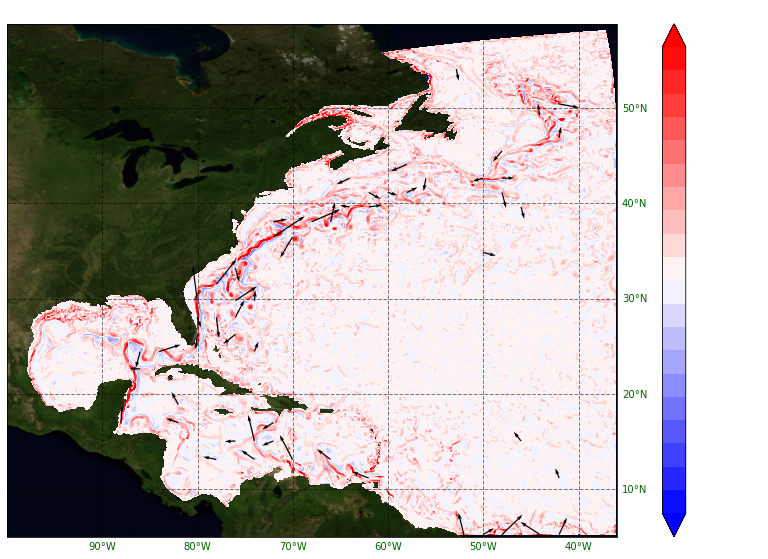

In [42]:
img = plt.imread('/Users/james/Documents/Github/nwa25/misc/images/bluemarble.png')
img_extent = (-180, 180, -90, 90)

fig = plt.figure(figsize=[12.8,7.2])
left = 0.01
bottom = 0.01
width = 0.99
height = 0.99 #0.95
ax2 = plt.axes([left, bottom, width, height], projection=ccrs.PlateCarree(), extent=[-100, -36, 5, 55], facecolor='black')
ax2.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree(), vmin=0,vmax=255)
field = ax2.contourf(ds_grid['geolon_c'], ds_grid['geolat_c'], vortplt, np.arange(-0.5,0.505,0.05), cmap=cm.bwr, extend='both' )#, np.arange(-2,38.5,0.5), cmap=cm.gist_ncar)


for q in range(0,len(ds_grid.yh)-50,50):
    for z in range(50,len(ds_grid.xh)-50,50):
        if ds.ssu[q,z] > 0.3 or ds.ssv[q,z] > 0.3 or ds.ssu[q,z] < -0.3 or ds.ssv[q,z] < -0.3:
            ax2.quiver(ds_grid['geolon_c'][q,z],ds_grid['geolat_c'][q,z],ds.ssu[q,z],ds.ssv[q,z], scale=20, width=0.002)

cb = plt.colorbar(field, ticks=[-0.5, -0.25, 0, 0.25, 0.5])
cb.ax.yaxis.set_tick_params(color='w')
cb.set_label('$\zeta / f$', color='w', fontsize=18)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.left_labels = False
gl.right_labels=True
gl.bottom_labels=True
gl.xlines = True
gl.ylines = True
gl.xlocator = mticker.FixedLocator([-100,-90,-80,-70, -60, -50, -40])
gl.ylocator = mticker.FixedLocator([10, 20, 30, 40, 50])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'darkgreen', 'weight': 'normal'}
gl.ylabel_style = {'color': 'darkgreen', 'weight': 'normal'}
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='w', fontsize=14)
plt.title(str("Hurricane Hortense: NWA25 Vorticity: " + ds['time'].dt.strftime("%Y-%m-%d %H:%M:%S").values), fontsize=14, color='w')


In [50]:
import xarray as xr

b = xr.open_dataset("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/nwa25/ocean_mask.nc")

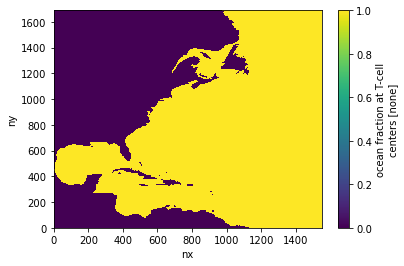

In [51]:
b.mask.plot()

In [56]:
c = b.where(b['mask'] == 1, np.nan)

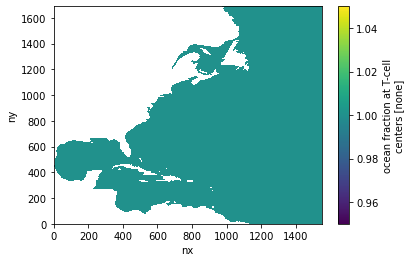

In [57]:
c.mask.plot()

In [60]:
import xarray
def get_coast_mask(mask_file):
    mask = xarray.open_dataset(mask_file)
    #mask = maskmask.where(ocn_mask == 1, np.nan)
    # Alistair's method of finding coastal cells
    ocn_mask = mask.mask.values
    #ocn_mask = 
    cst_mask = 0 * ocn_mask # All land should be 0
    is_ocean = ocn_mask > 0
    cst_mask[(is_ocean) & (np.roll(ocn_mask, 1, axis=1) == 0)] = 1 # Land to the west
    cst_mask[(is_ocean) & (np.roll(ocn_mask, -1, axis=1) == 0)] = 1 # Land to the east
    cst_mask[(is_ocean) & (np.roll(ocn_mask, 1, axis=0) == 0)] = 1 # Land to the south
    cst_mask[(is_ocean) & (np.roll(ocn_mask, -1, axis=0) == 0)] = 1 # Land to the north

    # Model boundaries are not coasts
    cst_mask[0, :] = 0
    cst_mask[:, 0] = 0
    cst_mask[-1, :] = 0
    cst_mask[:, -1] = 0

    return cst_mask

get_coast_mask("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/nwa25/ocean_mask.nc")

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])